# Moon position and phase prediction

## 0. Introduction

This notebook contains the tutorial of how to predict the position and phase of the moon at any time. We will show you how to train a machine learning model that performs well on the prediction. We will first make prediction on the positions of the moon. We will do featurization on the input data(i.e. the time) and show you how to select the optimum fourier features. Then we will try different machine learning models like linear regression, ridge regression, lasso, neural network, etc. We will compare these models and select a best one. Finally we will use the best model to make prediction on the moon phase. 

\* For the information of planets and the sun, please view other notebooks

## 1. Data generation
Here we generate the position data using method from Team Jupyter. We generate the moon phase data from Pylunar since Team Jupyter didn't provide enough lunar information.

We generate the data from year 118AC to 218AC at Luoyang(34.6202N, 12.4539E) where is the capital of China in Eastern Han Dynasty. 


In [14]:
import urllib.request # URL handling modules
from bs4 import BeautifulSoup # pulling data out of HTML
import numpy as np # cientific computing
import datetime # basic date and time types
import jdcal # functions for converting between Julian dates and calendar dates
import pandas as pd # data analysis
from tqdm import tqdm # progress bars
import pickle # object serialization
import pylunar as lunar

In [2]:
def post_request(command,values):
    '''
    This function is used to send a POST request to the API,
    where the options are defined in a dictionary.
    These kinds of requests are used to make a change on Stellarium,
    such us to change the current time or location.
    '''
    url = 'http://localhost:8090/api/' + command
    data = urllib.parse.urlencode(values)
    data = data.encode('ascii') # data should be bytes
    req = urllib.request.Request(url, data)
    with urllib.request.urlopen(req) as response:
       x = response.read()
    return x

In [3]:
def get_request(command):
    '''
    This function is used to send a GET request to the API. No options required.
    These kinds of requests are used to retrieve data from Stellarium.
    '''
    url = 'http://localhost:8090/api/' + command
    req = urllib.request.Request(url)
    with urllib.request.urlopen(req) as response:
       html = response.read()
    return html

In [4]:
def locate_line(soup,elm):
    '''
    This function is used to parse the html retrieved using the 
    get_request function. It tries to find the line in which 
    the string passed by the elm variable appears and return what's after that.
    It's purpose is to extract a specific piece of information and return it as text,
    such as the hour angle or the distance from the sun.
    '''
    return [line.replace(elm,'').strip() for line in soup.prettify().split('\n') if elm in line][0]

In [5]:
def hrmnsec_to_hr(time):
    """
    Converts a string of the form '1h10m10.59s' to
    a floating point real number corresponding to hours
    """
    return float(time.split('h')[0].strip()) + \
    float(((time.split('h')[1]).split('m'))[0])/60. + \
    float((time.split('h')[1]).split('m')[1].replace('s',''))/(60.**2)

In [6]:
def ang_to_real(angle):
    """
    Converts a string representing an angle of the form '+4°57\'33.4"'
    to the corresponding angle in degrees.
    """
    return float(angle.replace('"','').split('°')[0]) + \
    float((angle.replace('"','').split('°')[1]).split("'")[0])/60.00 + \
    float((angle.replace('"','').split('°')[1]).split("'")[1])/(60.0**2)

In [7]:
def get_location(body_name):
    '''
    This function sends a GET request to retrieve information for a given
    celestial body. It returns a python list containing the quantities we
    are interested in.
    '''
    call = 'objects/info?name=' + body_name
    # API call
    html = get_request(call)
    soup = BeautifulSoup(html,'html.parser')
    
    # Get RA, Dec.
    [ra, dec] = locate_line(soup,'RA/Dec (on date):').split('/')
    # get Az. Alt.
    [az, alt] = locate_line(soup,'Az./Alt.:').split('/')
    # get distance from Earth (in AU)
    distEarth = float(locate_line(soup,'Distance:').split('AU')[0].strip())
    # get distance from the Sun (in AU)
    if body_name != 'Sun':
        distSun = float(locate_line(soup,'Distance from Sun:').split('AU')[0].strip())
    else:
        distSun = 0.00
    const = locate_line(soup,'IAU Constellation:')
    # Parse times, angles and convert to float
    ra = hrmnsec_to_hr(ra)
    dec = ang_to_real(dec)
    az = ang_to_real(az)
    alt = ang_to_real(alt.replace(' (apparent)','').strip())
    return [ra,dec,az,alt,distEarth,distSun,const]

In [8]:
def update_location(lat,long):
    """
    Use the API to change the location of the observer on Earth .
    Latitude corresponds to degrees North
    Longitude corresponds to degrees EAST << be careful!
    """
    url = 'location/setlocationfields'
    values = {'latitude' : str(lat),
          'longitude' : str(long),
         'altitude' : '0.00'}
    res = post_request(url,values)

In [9]:
def update_time(JD):
    """
    Use the API to change the universal time (JD) 
    for which the quantities are reported.
    The unit is Julian Day
    https://en.wikipedia.org/wiki/Julian_day
    """
    url = 'main/time'
    values = {'time' : JD,
          'timerate' : 0.00}
    res = post_request(url,values)

In [10]:
def get_JD_from_date(year,month,day):
    """
    Convert calendar day to Julian Day
    """

    return sum(jdcal.gcal2jd(year, month, day))

In [11]:
from jdcal import MJD_0
def get_date_from_JD(JD):
    """
    Convert Julian Day to calendar day
    """
    return jdcal.jd2gcal(MJD_0,JD-MJD_0)

In [18]:
def get_position(bodies= ['Moon'], year=[118,218], n_daily_samples=0.1, loc=[34.6202,112.4539]):
    """
    Get the positions dataframe of the moon
    """


    start_date = get_JD_from_date(year[0],1,1) # Set a start date (year, month day)
    end_date = get_JD_from_date(year[1],1,1) # Set and end date

    # Number of days
    n_days = end_date - start_date

    # Number of samples
    n_samples = int(n_daily_samples * n_days)
    # observation location
    n_locs = 1
    locs = np.random.rand(n_locs,2) # initialize array
    locs[:,0] = loc[0]
    locs[:,1] = loc[1]
    
    n_rows = int(n_samples * n_locs * len(bodies))

    floats = np.full((n_rows,6),0.00)
    constelations = np.full((n_rows),'',dtype=object)       
    # Create a numpy array containing all datetimes of interset
    JD_array = np.arange(start_date,end_date-1,(end_date-start_date)/n_samples)

    i = 0                              # Counter variable

    update_location(*locs[i])          # Update the location (only once in this case)
                                    # ~So we took it out of the loop for faster execution~

    for JD in tqdm(JD_array):          # For each datetime
        update_time(JD)                # Set Stellarium to this datetime
        for body in bodies:            # And then for each celestial body of interest
            tmp = get_location(body)   # Get data for that body
            floats[i,:] = tmp[0:-1]    # Store all the numeric data
            constelations[i] = tmp[-1] # And the constellation info in a char. array
            i += 1                     # Next row

    # Now that we have gathered the observations, we can create the dataframe.
    body_name_array = np.array(bodies * n_samples)
    # We won't store the longitude and latitude in the dataframe. It will be always the same, and there is no need to repeat that information so many times.
    df = pd.DataFrame(data = {'JD' : JD_array.repeat(len(bodies)),
                            'Body'     : body_name_array,
                            'RA'       : floats[:,0],
                            'Dec'      : floats[:,1],
                            'Az'       : floats[:,2],
                            'Alt'      : floats[:,3],
                            'Dist'     : floats[:,4],
                            'Dist_Sun' : floats[:,5],
                            'Const'    : constelations 
    })
    del floats
    del constelations

    return df

In [42]:
def get_phase(position=[(34,13,49),(112,28,25)], year = [118,218], n_daily_samples=0.1):
    """
    Get the moon phase dataframe
    """
    PhaseName={
        'NEW_MOON': 0,
        'WAXING_CRESCENT': 1,
        'FIRST_QUARTER': 2,
        'WAXING_GIBBOUS': 3,
        'FULL_MOON': 4,
        'WANING_GIBBOUS': 5,
        'LAST_QUARTER': 6,
        'WANING_CRESCENT': 7}
    # collect the dates
    start_date = get_JD_from_date(year[0],1,1) 
    end_date = get_JD_from_date(year[1],1,1) 
    n_days = end_date - start_date
    n_samples = int(n_daily_samples * n_days)

    # collect the moon phase info
    # return the illuminated fraction and the phase name of the moon
    moon = lunar.MoonInfo(position[0],position[1])
    jd_array = np.linspace(start_date, end_date, n_samples)
    phase_array=[]
    phase_fraction_array=[]

    for jd in tqdm(jd_array):
        date = get_date_from_JD(jd)
        moon.update((date[0], date[1], date[2], date[3], 0, 0))
        
        phase_array.append(PhaseName[moon.phase_name()])
        phase_fraction_array.append(moon.fractional_phase())

    phase_array = np.array(phase_array)
    phase_fraction_array = np.array(phase_fraction_array)

    #df = pd
    return pd.DataFrame(data = {'JD': jd_array, 
                                'Phase': phase_array, 
                                'Frac': phase_fraction_array})
    #jd_array.reshape(-1,1), phase_array.reshape(-1,1), phase_fraction_array.reshape(-1,1)

### 1.1 get the moon positions

In [19]:
df_position = get_position(bodies=['Moon'], year=[118,218], n_daily_samples=0.1, loc=[34.6202,112.4539])

100%|██████████| 3652/3652 [01:09<00:00, 52.80it/s]


In [28]:
# save data
df_position.to_pickle('moon_position.df')

### 1.2 get the moon phase

In [43]:
df_phase = get_phase(position=[(34,37,13),(112,27,14)], year=[118, 218],n_daily_samples=0.1)

100%|██████████| 3652/3652 [00:04<00:00, 816.48it/s]


In [45]:
# save data
df_phase.to_pickle('moon_phase.df')

## 2. Prediction on the moon positions
We will only predict the azimuth, altitude of the moon since they are the only observed data. We will also predict distance from the moon to the earth, just for interest.

In [88]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import numpy as np

In [55]:
def featurize(df, n_feature=100):
    
    X =pd.DataFrame(df['JD'])
    JD = np.array(X).reshape(-1,1)
    t = np.subtract(JD, JD[0])

    for omega in np.linspace(0, 2*np.pi, num=n_feature):
        X['sin'+str(omega)] = np.array(np.sin(omega*t))
        X['cos'+str(omega)] = np.array(np.cos(omega*t))
    
    return JD, np.array(X.drop(['JD'],axis=1))

In [97]:
def moon_plot(x_train, y_train, y_train_p, x_test, y_test, y_test_p, target, name):
    plt.figure()
    plt.plot(x_train[-100:], y_train[-100:], label='train_true')
    plt.plot(x_train[-100:], y_train_p[-100:], label='train_pred')
    plt.plot(x_test[:50], y_test[:50], label='test_true')
    plt.plot(x_test[:50], y_test_p[:50], label='test_pred')
    plt.xlabel('time JD')
    plt.ylabel(target)
    plt.legend()

    plt.savefig(name+target, dpi=600)

we use fourier features to featurize our time. Based on previous research, we find 3000 order is suitable for training. 

In [61]:
JD, JD_feature = featurize(df_position, n_feature=3000)

### 2.1 use linear regression model

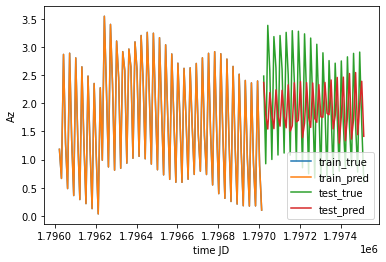

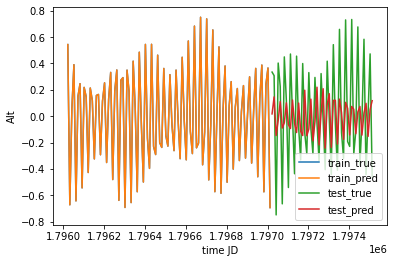

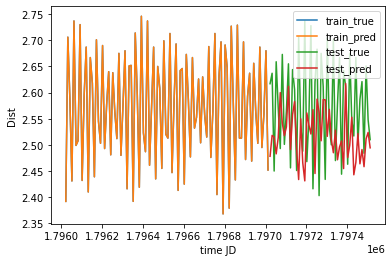

In [112]:
mse_linear = {}

#y_train_preds = {}
#y_test_preds ={}

#target = 'Az'
for target in ['Az', 'Alt', 'Dist']:
    mse_linear[target] = []
    y_trains[target] = []
    y_tests[target] = []
    y_train_preds[target] = []
    y_test_preds[target] = []

    x_train, x_test, y_train, y_test = train_test_split(JD_feature, df_position[target], test_size = 0.1, shuffle = False)
    if target == 'Dist':
        y_train *= 1000
        y_test *= 1000
    elif target == 'Az':
        y_train /= 100
        y_test /= 100
    elif target == 'Alt':
        y_train /= 100
        y_test /= 100

    reg = LinearRegression()
    reg.fit(x_train, y_train)
    y_train_pred = reg.predict(x_train)
    y_test_pred = reg.predict(x_test)

    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)

    mse_linear[target].append((mse_train, mse_test))

    moon_plot(JD[:len(x_train)], y_train, y_train_pred, JD[-len(x_test):], y_test, y_test_pred, target, name='linear')
#y_train_preds[target].append(y_train_pred)
#y_test_preds[target].append(y_test_pred)


In [113]:
mse_linear

{'Az': [(1.0957223223302327e-28, 0.9059323446551696)],
 'Alt': [(1.559610250232614e-29, 0.13150124961987955)],
 'Dist': [(1.3851878950472422e-30, 0.014944160618251892)]}

### 2.2 use ridge regression model

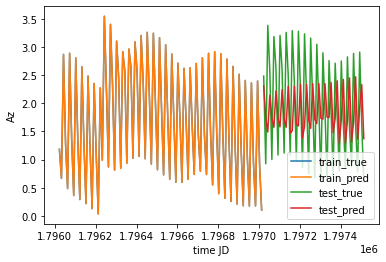

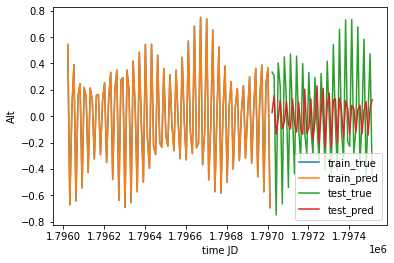

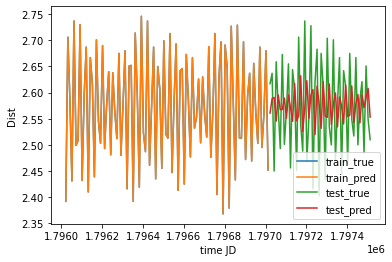

In [114]:
mse_ridge = {}

#y_train_preds = {}
#y_test_preds ={}

#target = 'Az'
for target in ['Az', 'Alt', 'Dist']:
    mse_ridge[target] = []
    y_trains[target] = []
    y_tests[target] = []
    y_train_preds[target] = []
    y_test_preds[target] = []

    x_train, x_test, y_train, y_test = train_test_split(JD_feature, df_position[target], test_size = 0.1, shuffle = False)
    if target == 'Dist':
        y_train *= 1000
        y_test *= 1000
    elif target == 'Az':
        y_train /= 100
        y_test /= 100
    elif target == 'Alt':
        y_train /= 100
        y_test /= 100

    reg = GridSearchCV(Ridge(), param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3]})
    reg.fit(x_train, y_train)
    y_train_pred = reg.predict(x_train)
    y_test_pred = reg.predict(x_test)

    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)

    mse_ridge[target].append((mse_train, mse_test))

    moon_plot(JD[:len(x_train)], y_train, y_train_pred, JD[-len(x_test):], y_test, y_test_pred, target, name='ridge')
#y_train_preds[target].append(y_train_pred)
#y_test_preds[target].append(y_test_pred)

In [115]:
mse_ridge

{'Az': [(1.0846647511911551e-13, 0.90438164215242)],
 'Alt': [(1.485017778465865e-14, 0.1315001780474985)],
 'Dist': [(1.3161305177096191e-09, 0.012000102828893047)]}

### 2.3 use lasso rigression model

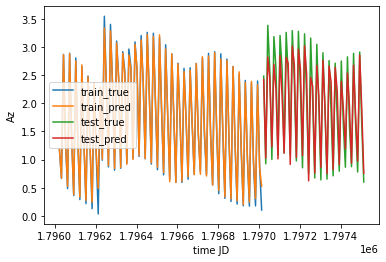

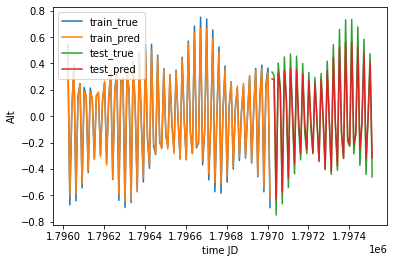

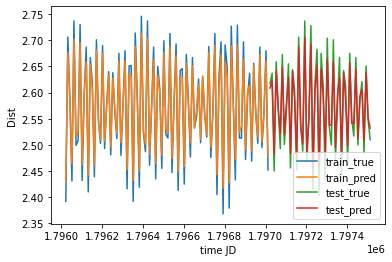

In [116]:
mse_lasso = {}

#y_train_preds = {}
#y_test_preds ={}

#target = 'Az'
for target in ['Az', 'Alt', 'Dist']:
    mse_lasso[target] = []
    y_trains[target] = []
    y_tests[target] = []
    y_train_preds[target] = []
    y_test_preds[target] = []

    x_train, x_test, y_train, y_test = train_test_split(JD_feature, df_position[target], test_size = 0.1, shuffle = False)
    if target == 'Dist':
        y_train *= 1000
        y_test *= 1000
    elif target == 'Az':
        y_train /= 100
        y_test /= 100
    elif target == 'Alt':
        y_train /= 100
        y_test /= 100


    reg = GridSearchCV(Lasso(), param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3],"tol": [1, 0.1, 0.01, 1e-4]})
    reg.fit(x_train, y_train)
    y_train_pred = reg.predict(x_train)
    y_test_pred = reg.predict(x_test)

    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)

    mse_lasso[target].append((mse_train, mse_test))

    moon_plot(JD[:len(x_train)], y_train, y_train_pred, JD[-len(x_test):], y_test, y_test_pred, target, name='lasso')
#y_train_preds[target].append(y_train_pred)
#y_test_preds[target].append(y_test_pred)

In [117]:
mse_lasso

{'Az': [(0.004348464489838538, 0.21383092362414313)],
 'Alt': [(0.002380767292738783, 0.02711320582209767)],
 'Dist': [(0.00029422369174384664, 0.002467748698749637)]}

### 2.4 Conclusion: It is obvious that Lasso is good at making prediction on the test set, just as we expected

## 3. Prediction on moon phase

### 3.1 use Lasso method

In [129]:
def phase_name(y_test, date=10):
    if date == 0:
        warning = 'This is the first date in your test set.\nPlease select more data before this date.'
        return warning
    elif date >= len(y_test) - 1:
        warning = 'This is the last date in your test set.\nPlease select more data after this date.'
        return warning
    
    frac = y_test[date]
    frac_b = y_test[date - 1]
    frac_a = y_test[date + 1]

    if frac >= 0.9:
        phase = 'FullMoon'
    elif frac <= 0.1:
        phase = 'NewMoon'
    elif frac > 0.1 and frac < 0.49:
        if frac_b < frac and frac_a > frac:
            phase = 'WaxingCrescent'
        else:
            phase = 'WaningCrescent'
    elif frac >= 0.49 and frac <= 0.51:
        if frac_b < frac and frac_a > frac:
            phase = 'FirstQuarter'
        else:
            phase = 'ThirdQuarter'
    elif frac > 0.51 and frac < 0.9:
        if frac_b < frac and frac_a > frac:
            phase = 'WaxingGibbous'
        else:
            phase = 'WaningGibbous'
    
    return phase

Let's first see what fraction of illumination looks like

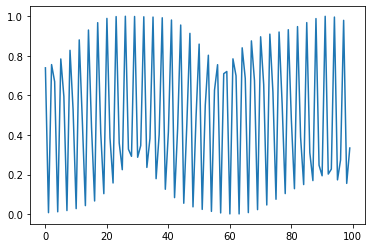

In [120]:
plt.plot(range(100), df_phase['Frac'][:100])

It is good to see that this is still a periodic function, so we can directly use the featurization and Lasso method to predict the fraction of illumination. Then we can classify the moon phase based on its illumination.

In [121]:
x_train, x_test, y_train, y_test = train_test_split(JD_feature, df_phase['Frac'], test_size = 0.1, shuffle = False)
reg = GridSearchCV(Lasso(), param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3],"tol": [1, 0.1, 0.01, 1e-4]})
reg.fit(x_train, y_train)
y_train_pred = reg.predict(x_train)
y_test_pred = reg.predict(x_test)

In [123]:
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
mse_train, mse_test

(0.00022316076507725852, 0.012163463111694387)

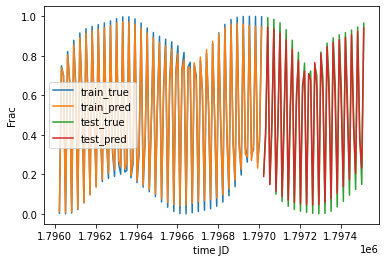

In [122]:
moon_plot(JD[:len(x_train)], y_train, y_train_pred, JD[-len(x_test):], y_test, y_test_pred, target='Frac', name='lasso')

Predict the name of moon phase

In [133]:
phase_name(y_test_pred, date=100)

'WaningCrescent'

### use neural network

There are totally 8 moon phase so we can consider the prediction task as a classification problem. Let's build some neural network and see how it works

In [134]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.utils import to_categorical


In [135]:
x_train, x_test, y_train, y_test = train_test_split(JD_feature, df_phase['Phase'], test_size = 0.1, shuffle = False)

In [136]:
y_train_hot = to_categorical(y_train)
y_test_hot = to_categorical(y_test)

In [140]:
x_train_partial, x_val, y_train_partial, y_val = train_test_split(x_train, y_train_hot, test_size=0.2, random_state=64)

In [148]:
model = Sequential()
model.add(Dense(2, activation='relu', input_shape=(x_train_partial.shape[1], )))
model.add(Dense(8, activation='relu'))
#model.add(layers.Dropout(0.5))
model.add(Dense(16, activation='relu'))
#model.add(Dense(128, activation='relu'))
#model.add(layers.Dropout(0.5))
#model.add(Dense(256, activation='relu'))
#model.add(Dense(256, activation='relu'))
#model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [149]:
n_epoch = 50
b_size = 128
 
history = model.fit(x_train_partial, y_train_partial, epochs=n_epoch, batch_size=b_size, validation_data=(x_val, y_val))

Epoch 1/50
21/21 [==============================] - 0s 7ms/step - loss: 2.0826 - accuracy: 0.2207 - val_loss: 2.0542 - val_accuracy: 0.2325
Epoch 2/50
21/21 [==============================] - 0s 3ms/step - loss: 1.9855 - accuracy: 0.2397 - val_loss: 2.0083 - val_accuracy: 0.2325
Epoch 3/50
21/21 [==============================] - 0s 3ms/step - loss: 1.8828 - accuracy: 0.2435 - val_loss: 1.9656 - val_accuracy: 0.2325
Epoch 4/50
21/21 [==============================] - 0s 3ms/step - loss: 1.7541 - accuracy: 0.2458 - val_loss: 1.9377 - val_accuracy: 0.2325
Epoch 5/50
21/21 [==============================] - 0s 4ms/step - loss: 1.6578 - accuracy: 0.2432 - val_loss: 1.9121 - val_accuracy: 0.2325
Epoch 6/50
21/21 [==============================] - 0s 4ms/step - loss: 1.5550 - accuracy: 0.2565 - val_loss: 1.8945 - val_accuracy: 0.2325
Epoch 7/50
21/21 [==============================] - 0s 4ms/step - loss: 1.4798 - accuracy: 0.3120 - val_loss: 1.8836 - val_accuracy: 0.1626
Epoch 8/50
21/21 [==

train_accuracy 0.6015982031822205
val_accuracy 0.23252280056476593


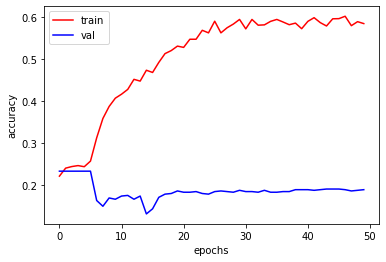

In [154]:
acc, acc_val = history.history['accuracy'], history.history['val_accuracy']
print('train_accuracy ' + str(np.max(acc)))
print('val_accuracy ' + str(np.max(acc_val)))

plt.plot(range(n_epoch), acc, c='r', label='train')
plt.plot(range(n_epoch), acc_val, c='b', label='val')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.savefig('nn',dpi=600)

The result looks really bad. Let's try to get more training data since it is obvious that the model is overfitted while training accuracy is low.

In [155]:
df_phase_more = get_phase(position=[(34,37,13),(112,27,14)], year=[118, 218],n_daily_samples=1)

100%|██████████| 36524/36524 [00:47<00:00, 762.01it/s]


In [156]:
JD_more, JD_feature_more = featurize(df_phase_more, n_feature=3000)

x_train, x_test, y_train, y_test = train_test_split(JD_feature_more, df_phase_more['Phase'], test_size = 0.1, shuffle = False)

In [157]:
y_train_hot = to_categorical(y_train)
y_test_hot = to_categorical(y_test)
x_train_partial, x_val, y_train_partial, y_val = train_test_split(x_train, y_train_hot, test_size=0.2, random_state=64)

In [170]:
model = Sequential()
model.add(Dense(8, activation='relu', input_shape=(x_train_partial.shape[1], )))
model.add(Dense(16, activation='relu'))
#model.add(layers.Dropout(0.5))
model.add(Dense(16, activation='relu'))
#model.add(Dense(128, activation='relu'))
#model.add(layers.Dropout(0.5))
#model.add(Dense(256, activation='relu'))
#model.add(Dense(256, activation='relu'))
#model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
#model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [171]:
n_epoch = 100
b_size = 128
 
history = model.fit(x_train_partial, y_train_partial, epochs=n_epoch, batch_size=b_size, validation_data=(x_val, y_val))

Epoch 1/100
206/206 [==============================] - 1s 3ms/step - loss: 1.8434 - accuracy: 0.2276 - val_loss: 1.5585 - val_accuracy: 0.2154
Epoch 2/100
206/206 [==============================] - 0s 2ms/step - loss: 1.5748 - accuracy: 0.2557 - val_loss: 1.5244 - val_accuracy: 0.2141
Epoch 3/100
206/206 [==============================] - 0s 2ms/step - loss: 1.5113 - accuracy: 0.2773 - val_loss: 1.5271 - val_accuracy: 0.2307
Epoch 4/100
206/206 [==============================] - 0s 2ms/step - loss: 1.4588 - accuracy: 0.3013 - val_loss: 1.5277 - val_accuracy: 0.2475
Epoch 5/100
206/206 [==============================] - 1s 2ms/step - loss: 1.3947 - accuracy: 0.3369 - val_loss: 1.5239 - val_accuracy: 0.2694
Epoch 6/100
206/206 [==============================] - 0s 2ms/step - loss: 1.3397 - accuracy: 0.3555 - val_loss: 1.5326 - val_accuracy: 0.2826
Epoch 7/100
206/206 [==============================] - 0s 2ms/step - loss: 1.2816 - accuracy: 0.3787 - val_loss: 1.5484 - val_accuracy: 0.3069

train_accuracy 0.5546090602874756
val_accuracy 0.3525475263595581


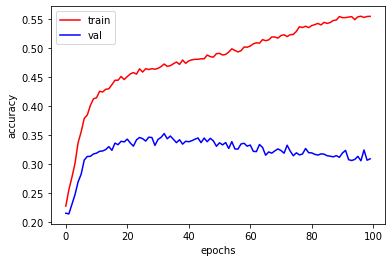

In [172]:
acc, acc_val = history.history['accuracy'], history.history['val_accuracy']
print('train_accuracy ' + str(np.max(acc)))
print('val_accuracy ' + str(np.max(acc_val)))

plt.plot(range(n_epoch), acc, c='r', label='train')
plt.plot(range(n_epoch), acc_val, c='b', label='val')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.savefig('nn_more',dpi=600)

The result looks better, but the model is still overfitted. Validation accuracy is still low. We assume that the NN model can be further improved by tuning the number of hidden layers and neurons. This should be done through trial and erros. Also experience is important. We have changed the number of layers for several time but the result is still bad since we lack certain experience. We suggest the readers to try the tuning on your own to get a better results.

### 3.3 Conclusion: 
Based on above results, we suggest to use Lasso for beginners. Neural network could be improved better if the users are more experienced. 